<a href="https://colab.research.google.com/github/Anagh3/mainproject/blob/main/Mainproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
#path='/content/gdrive/MyDrive/StyleTransfer'
path='/content/gdrive/MyDrive/Styletransfer'
os.chdir(path)
!dir

Code.ipynb  dataset  Papers


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

import tensorflow as tf
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
# Set up some global values here
content_path = os.path.join(path,'dataset','images','COCO_train2014_000000001145.jpg')
style_path = os.path.join(path,'dataset','styles','psyche.jpg')

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  img = kp_image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return img


def imshow(img, title=None):

  # Remove the batch dimension
  out = np.squeeze(img, axis=0)

  # Normalize for display
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

<ipython-input-5-b460b7463a2d>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)


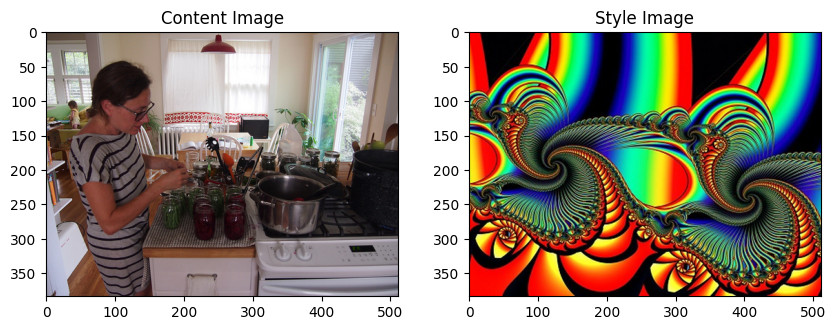

In [ ]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [ ]:
# preprocessing

#load and preprocess for resnet
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.resnet50.preprocess_input(img)
  return img

def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")

  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
#creating resnet50 model with pretrained weight
resnet = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
#defining content and style layers

content_layers = ['conv1_relu']
style_layers = ['conv2_block2_1_relu', 'conv3_block2_1_relu', 'conv4_block6_1_relu', 'conv5_block3_1_relu']

In [ ]:
#creating a model for feature extraction
def get_model():
    #  Creates a model with access to intermediate layers.

    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
    resnet.trainable = False

    # Get the outputs of the content and style layers
    content_outputs = [resnet.get_layer(name).output for name in content_layers]
    style_outputs = [resnet.get_layer(name).output for name in style_layers]

    # Combine content and style outputs
    model_outputs = style_outputs + content_outputs

    # Build the model
    return tf.keras.models.Model(resnet.input, model_outputs)

# Create the model
model = get_model()

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # Extracting features from intermediate layers
    content_outputs = model(content_image)
    style_outputs = model(style_image)

    # Extracting feature maps from specific layers
    content_features = [content_layer[0] for content_layer in content_outputs]
    style_features = [style_layer[0] for style_layer in style_outputs]

    return content_features, style_features

content_features, style_features = get_feature_representations(resnet, content_path, style_path)


<ipython-input-5-b460b7463a2d>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)


In [ ]:
content_features, style_features = get_feature_representations(resnet, content_path, style_path)

print("Content Features Shape:", content_features[0].shape)
print("Style Features Shape:", style_features[0].shape)

import numpy as np

content_features_mean = np.mean(content_features[0], axis=(0, 1))
content_features_std = np.std(content_features[0], axis=(0, 1))
print("Content Features Mean:", content_features_mean)
print("Content Features Std Deviation:", content_features_std)

style_features_mean = np.mean(style_features[0], axis=(0, 1))
style_features_std = np.std(style_features[0], axis=(0, 1))
print("Style Features Mean:", style_features_mean)
print("Style Features Std Deviation:", style_features_std)

<ipython-input-5-b460b7463a2d>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)


Content Features Shape: (16, 2048)
Style Features Shape: (16, 2048)
Content Features Mean: 0.11411473
Content Features Std Deviation: 0.859357
Style Features Mean: 0.32863998
Style Features Std Deviation: 1.3673419


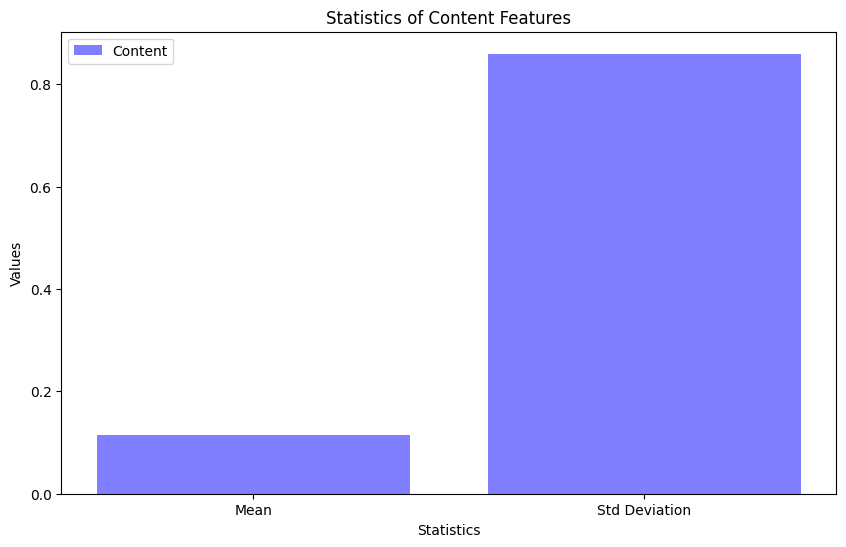

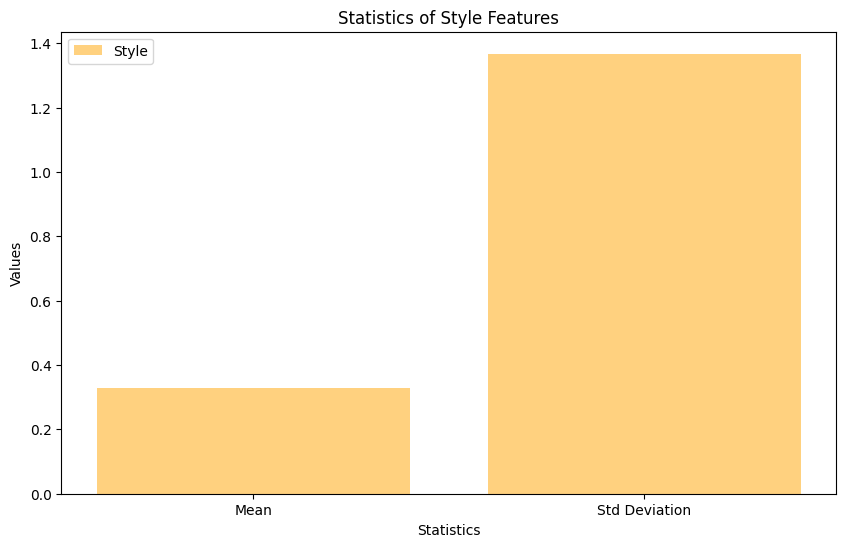

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define labels for the statistics
labels = ['Mean', 'Std Deviation']

# Define values for the statistics
content_stats = [content_features_mean, content_features_std]
style_stats = [style_features_mean, style_features_std]

# Plot bar plots for content features
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(labels)), content_stats, color='blue', alpha=0.5, label='Content')
plt.xticks(np.arange(len(labels)), labels)  # Set labels for x-axis
plt.xlabel('Statistics')
plt.ylabel('Values')
plt.title('Statistics of Content Features')
plt.legend()
plt.show()

# Plot bar plots for style features
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(labels)), style_stats, color='orange', alpha=0.5, label='Style')
plt.xticks(np.arange(len(labels)), labels)  # Set labels for x-axis
plt.xlabel('Statistics')
plt.ylabel('Values')
plt.title('Statistics of Style Features')
plt.legend()
plt.show()


In [ ]:
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def style_loss(base_style, gram_target):
    _, height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target)) / (4. * (channels ** 2) * (width * height) ** 2)

def total_variation_loss(image):
    x_deltas = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_deltas = image[:, 1:, :, :] - image[:, :-1, :, :]
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

def gram_matrix(input_tensor):
    # Flatten the feature map
    channels = int(input_tensor.shape[-1])
    flattened_tensor = tf.reshape(input_tensor, [-1, channels])

    # Compute the Gram matrix
    gram = tf.matmul(flattened_tensor, flattened_tensor, transpose_a=True)

    return gram


In [ ]:
import tensorflow as tf
# Sample inputs for testing
base_content = tf.constant([[1, 2, 3], [4, 5, 6]], dtype=tf.float32)
target_content = tf.constant([[2, 3, 4], [5, 6, 7]], dtype=tf.float32)

base_style = tf.constant([[[1, 2], [3, 4]], [[5, 6], [7, 8]]], dtype=tf.float32)
gram_target = tf.constant([[1, 2], [3, 4]], dtype=tf.float32)

image = tf.constant([[[1, 2], [3, 4]], [[5, 6], [7, 8]]], dtype=tf.float32)

# Reshape image tensor to have the correct shape
image = tf.expand_dims(image, axis=-1)  # Assuming image is grayscale

# Test content_loss function
content_loss_value = content_loss(base_content, target_content)
print("Content Loss:", content_loss_value.numpy())

base_style = tf.expand_dims(base_style, axis=0)
# Test style_loss function
style_loss_value = style_loss(base_style, gram_target)
print("Style Loss:", style_loss_value.numpy())

# Test total_variation_loss function
tv_loss_value = total_variation_loss(image)
print("Total Variation Loss:", tv_loss_value.numpy())

# Test gram_matrix function
gram_matrix_value = gram_matrix(base_style)
print("Gram Matrix:", gram_matrix_value.numpy())


Content Loss: 1.0
Style Loss: 38.435547
Total Variation Loss: 12.0
Gram Matrix: [[ 84. 100.]
 [100. 120.]]
